# oven temperature determination

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo


In [2]:
#----pressure and effusion functions------
ovenHoleDiam=1e-3
ovenHoleArea=np.pi*(ovenHoleDiam/2)**2 #SI
m_Li=1.1623e-26 #kg
K_B=1.3806e-23 #botlzman, SI

def pressure_ABC(T,A,B,C):
    return 10**(A-(B/(T+C)))
@np.vectorize
def pressure_NIST(T):
    if not 298.14<=T<=1599.99:
        raise ValueError
    P1,P2=np.nan,np.nan
    if 298.14<=T<=1599.99:
        A,B,C=4.98831,7918.984,-9.52
        P1=pressure_ABC(T,A,B,C)
    if 1204<=T<=1353:
        A,B,C=1.58992,1603.966,-711.088
        P2=pressure_ABC(T,A,B,C)
    P_Bar=np.nanmean([P1,P2])  #these values agree
    assert np.isnan(P_Bar)==False
    P_Pa=100_000*P_Bar
    return P_Pa
def Q_Effusive(T,A=ovenHoleArea,m=m_Li):
    P=pressure_NIST(T)
    return P*A/np.sqrt(2*np.pi*m*K_B*T)
@np.vectorize
def peak_Signal_Fit(deltaT,T0,S0):
    return S0*pressure_NIST(T0+deltaT)/np.sqrt(T0+deltaT)

### Data
To fit the temperature function I need data in the form of the peak signal minus the background. I will keep it simple and use the fits file to get this. This works if I have the laser in the same place for a variety of temperatures.

Data below is from 1_27_2022

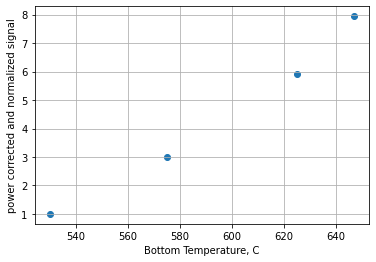

In [19]:
TBottom=np.asarray([530,575,625,647]) +273.0 #kelvin
TTop=np.asarray([610,653,700,715])+273.0 #kelvin
power=np.asarray([5.9,6.0,2.38,2.7]) #microwatts
signal=np.asarray([5330.0,16350.0,12750.0,19375.0])
signal=signal/power #correct signal for power
signal=signal/signal.min() #normalize signal
eps=.5 #eps of 0 if only the bottom temperature
deltaT=(TBottom-TBottom[0])+eps*((TTop-TBottom)-(TTop-TBottom)[0])
plt.scatter(TBottom-273,signal)
plt.ylabel('power corrected and normalized signal')
plt.xlabel('Bottom Temperature, C')
plt.grid()
plt.show()

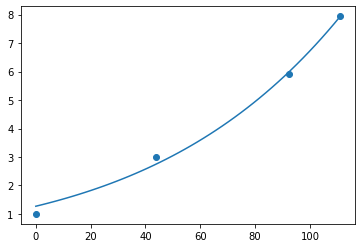

(991.5469687565462, 803.0)

In [11]:
guess=[800,2.0]
bounds=((300.0,0.0),(1590.0,np.inf))
params=spo.curve_fit(peak_Signal_Fit,deltaT,signal,p0=guess,bounds=bounds)[0]
deltaTPlot=np.linspace(deltaT.min(),deltaT.max())
plt.scatter(deltaT,signal)
plt.plot(deltaTPlot,peak_Signal_Fit(deltaTPlot,*params))
plt.show()
params[0],TBottom[0]

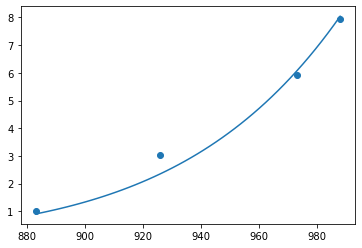

In [16]:
def wrapper( T,S0):
    return peak_Signal_Fit(0.0,T,S0)
eps=1.0
T_Lithium=TBottom+eps*(TTop-TBottom)
params=spo.curve_fit(wrapper,T_Lithium,signal)[0]
TPlot=np.linspace(T_Lithium.min(),T_Lithium.max())
plt.scatter(T_Lithium,signal)
plt.plot(TPlot,wrapper(TPlot,*params))
plt.show()

### Now I have data of total flux versus bottom oven temperature

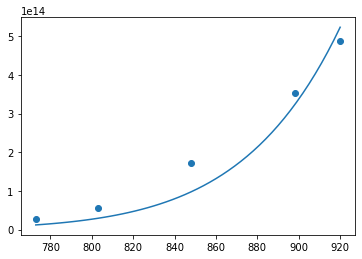

array([0.0010388])

In [40]:
def wrapper(T,Q0):
    return Q_Effusive(T)*Q0

T=np.asarray([500,530.0,575,625,647])+273
Flux=np.asarray([27.5,57,172,354,488])*1e12
# T+=100
guess=[1.0]
params=spo.curve_fit(wrapper,T,Flux,p0=guess)[0]
# params=guess
TPlot=np.linspace(T.min(),T.max())
plt.scatter(T,Flux)
plt.plot(TPlot,wrapper(TPlot,*params))
plt.show()
params

